# LLMs for Simulation II: Experiments

**Learning objectives:**
- Use LLMs to predict experimental outcomes before data collection
- Implement zero-shot experimental forecasting (Hewitt et al. approach)
- Understand fine-tuned behavioral models (Centaur approach)
- Apply both methods to real experimental designs
- Critically evaluate when simulation is appropriate

**How to run this notebook:**
- **Google Colab** (recommended for Part 2): Fine-tuning requires GPU
- **Local/Colab** (Part 1): Zero-shot prediction works anywhere
- **API key needed**: OpenAI for Part 1

**Key papers:**
- **Hewitt, Ashokkumar et al. (2024)**: Predicting Results of Social Science Experiments
- **Binz & Schulz et al. (2025)**: Centaur: Foundation Model of Human Cognition

---

## Introduction: Two Approaches to Experimental Simulation

This chapter demonstrates two complementary approaches to simulating experimental outcomes:

### Approach 1: Zero-shot prediction (Hewitt et al.)
- Use a **general-purpose LLM** (no fine-tuning)
- Prompt with demographic profiles + experimental conditions
- Generate simulated responses to predict treatment effects
- **Advantage**: Fast, no training data needed
- **Limitation**: Relies on LLM's prior knowledge

### Approach 2: Fine-tuned behavioral model (Centaur)
- **Fine-tune on real human behavioral data**
- Train on trial-by-trial choices across experiments
- Model learns general principles of human decision-making
- **Advantage**: More accurate predictions within domain
- **Limitation**: Requires large behavioral corpus

**When to use which:**
- **Zero-shot**: Quick forecasts before data collection, exploring many scenarios
- **Fine-tuned**: When you have behavioral data, need precision, studying specific paradigms

---

# Part 1: Zero-shot Experimental Prediction

We'll replicate the **Hewitt et al. (2024)** approach using a real preregistered experiment:

**Connors (2020): "Everyone's Doing It: Affective Polarization is Inflated by Social Pressure"**

**Research question**: Does perceived privacy affect how much affective polarization people report?

**Design**:
- **N = 3,333** participants
- **4 conditions**: Public, Private, Friends, Control
- **Outcome**: Affective polarization (feeling thermometers toward out-party)
- **Hypothesis**: Privacy increases → reported polarization decreases

**Actual results**:
- **No main effect** of privacy conditions
- Evidence that social pressure inflates polarization measures
- Effects depend on individual differences in social conformity

Let's see if an LLM can predict these findings!

---

## Setup

In [3]:
# Install packages
!pip install -q openai pandas numpy matplotlib seaborn scipy

In [10]:
import os
import json
import getpass
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from openai import OpenAI

# Set API key
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

client = OpenAI()

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete!")

Enter your OpenAI API key: ··········
✓ Setup complete!


---

## Step 1: Define the Experimental Setup

We need to translate the Connors study into prompts for the LLM:

1. **Study context**: Background about the survey
2. **Treatment conditions**: Four privacy manipulations
3. **Outcome measure**: Feeling thermometer (0-100)
4. **Demographic profiles**: Representative U.S. sample

---

In [5]:
# Study context
STUDY_CONTEXT = """
You are participating in a research study about political attitudes in America.
You will answer questions about how you feel toward different political groups.
"""

# Treatment conditions (exactly as in Connors 2020)
CONDITIONS = {
    'control': "",  # No reminder

    'public': """
Just a reminder, the results based on your responses may be published.
""",

    'private': """
Just a reminder, your responses are completely private.
""",

    'friends': """
Imagine your friends will read your responses to the following questions.
"""
}

# Outcome measure - feeling thermometer
# We'll ask about the out-party (opposite of respondent's party)
OUTCOME_TEMPLATE = """
On a scale from 0 to 100, where 0 means very cold/unfavorable and
100 means very warm/favorable, how do you feel toward {target_party}?

Respond with ONLY a number from 0 to 100.
"""

print("✓ Experimental setup defined")

✓ Experimental setup defined


---

## Step 2: Create Demographic Profiles

Following **Hewitt et al. (2024)**, we'll create realistic demographic profiles representing the U.S. population.

Key dimensions:
- **Political party**: Democrat, Republican, Independent
- **Age**: Range of age groups
- **Gender**: Male, Female
- **Education**: High school, Some college, College degree, Graduate degree
- **Region**: Different U.S. regions

---

In [6]:
def create_demographic_profiles(n_profiles=100):
    """
    Generate representative demographic profiles

    Following typical U.S. population distributions
    """
    np.random.seed(42)  # For reproducibility

    profiles = []

    # Demographic distributions (approximate U.S. proportions)
    parties = ['Democrat', 'Republican', 'Independent']
    party_probs = [0.35, 0.30, 0.35]

    ages = ['25-34', '35-44', '45-54', '55-64', '65+']
    age_probs = [0.20, 0.20, 0.20, 0.20, 0.20]

    genders = ['male', 'female']
    gender_probs = [0.49, 0.51]

    educations = ['high school diploma', 'some college', 'college degree', 'graduate degree']
    edu_probs = [0.25, 0.30, 0.30, 0.15]

    regions = ['Northeast', 'South', 'Midwest', 'West']
    region_probs = [0.17, 0.38, 0.21, 0.24]

    for i in range(n_profiles):
        party = np.random.choice(parties, p=party_probs)
        age = np.random.choice(ages, p=age_probs)
        gender = np.random.choice(genders, p=gender_probs)
        education = np.random.choice(educations, p=edu_probs)
        region = np.random.choice(regions, p=region_probs)

        # Determine out-party (target for feeling thermometer)
        if party == 'Democrat':
            out_party = 'Republicans'
        elif party == 'Republican':
            out_party = 'Democrats'
        else:  # Independent
            out_party = np.random.choice(['Democrats', 'Republicans'])

        profile = {
            'id': i,
            'party': party,
            'age': age,
            'gender': gender,
            'education': education,
            'region': region,
            'out_party': out_party,
            'description': f"a {age}-year-old {gender} {party} from the {region} with a {education}"
        }

        profiles.append(profile)

    return pd.DataFrame(profiles)

# Generate profiles
profiles_df = create_demographic_profiles(n_profiles=100)

print(f"Generated {len(profiles_df)} demographic profiles")
print("\nExample profiles:")
print(profiles_df[['description', 'out_party']].head())

Generated 100 demographic profiles

Example profiles:
                                         description    out_party
0  a 65+-year-old female Republican from the Nort...    Democrats
1  a 25-34-year-old female Democrat from the Midw...  Republicans
2  a 65+-year-old female Democrat from the South ...  Republicans
3  a 35-44-year-old female Democrat from the Sout...  Republicans
4  a 25-34-year-old male Republican from the Sout...    Democrats


---

## Step 3: Simulate Experimental Responses

Now we'll use GPT-4 to simulate how each demographic profile would respond in each condition.

**Key parameters:**
- **temperature = 1.0**: Allows realistic variation in responses
- **Multiple runs per profile**: Capture within-person variability
- **Extract numeric responses**: Parse feeling thermometer scores

**This takes ~5-10 minutes to run all simulations.**

---

In [7]:
def simulate_response(demographic_desc, out_party, condition_text,
                     model="gpt-4o", temperature=1.0, max_retries=3):
    """
    Simulate a single response from LLM

    Args:
        demographic_desc: String describing the respondent
        out_party: Target party for feeling thermometer
        condition_text: Treatment condition reminder
        model: Which OpenAI model to use
        temperature: Sampling temperature
        max_retries: Number of attempts if parsing fails

    Returns:
        int: Feeling thermometer score (0-100), or None if failed
    """
    outcome_question = OUTCOME_TEMPLATE.format(target_party=out_party)

    prompt = f"""You are {demographic_desc}.

{STUDY_CONTEXT}

{condition_text}

{outcome_question}"""

    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_tokens=10
            )

            # Extract numeric response
            content = response.choices[0].message.content.strip()

            # Try to parse as integer
            score = int(''.join(filter(str.isdigit, content)))

            # Validate range
            if 0 <= score <= 100:
                return score

        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Failed to parse response after {max_retries} attempts: {e}")
                return None
            time.sleep(0.5)

    return None

print("✓ Simulation function defined")

✓ Simulation function defined


In [17]:
profiles_df.loc[:10]

,id,party,age,gender,education,region,out_party,description
0,0,Republican,65+,female,college degree,Northeast,Democrats,a 65+-year-old female Republican from the Nort...
1,1,Democrat,25-34,female,college degree,Midwest,Republicans,a 25-34-year-old female Democrat from the Midw...
2,2,Democrat,65+,female,high school diploma,South,Republicans,a 65+-year-old female Democrat from the South ...
3,3,Democrat,35-44,female,some college,South,Republicans,a 35-44-year-old female Democrat from the Sout...
4,4,Republican,25-34,male,some college,South,Democrats,a 25-34-year-old male Republican from the Sout...
5,5,Independent,25-34,female,college degree,Northeast,Democrats,a 25-34-year-old female Independent from the N...
6,6,Independent,45-54,male,graduate degree,Midwest,Republicans,a 45-54-year-old male Independent from the Mid...
7,7,Democrat,25-34,female,some college,Northeast,Republicans,a 25-34-year-old female Democrat from the Nort...
8,8,Republican,25-34,female,some college,Midwest,Democrats,a 25-34-year-old female Republican from the Mi...
9,9,Democrat,45-54,female,high school diploma,West,Republicans,a 45-54-year-old female Democrat from the West...


In [19]:
def run_experiment_simulation(profiles_df, conditions, n_responses_per_profile=2):
    """
    Run full experimental simulation across all conditions and profiles

    Args:
        profiles_df: DataFrame of demographic profiles
        conditions: Dict of condition names and texts
        n_responses_per_profile: Number of responses to simulate per profile

    Returns:
        pd.DataFrame: All simulated responses
    """
    results = []
    total_simulations = 10 * len(conditions) * n_responses_per_profile
    completed = 0

    print(f"Starting simulation: {total_simulations} total responses to generate...")
    print(f"Estimated time: ~{total_simulations * 2 / 60:.1f} minutes\n")

    for _, profile in profiles_df.loc[:10].iterrows():
        for condition_name, condition_text in conditions.items():
            for response_num in range(n_responses_per_profile):
                score = simulate_response(
                    demographic_desc=profile['description'],
                    out_party=profile['out_party'],
                    condition_text=condition_text
                )

                results.append({
                    'profile_id': profile['id'],
                    'party': profile['party'],
                    'age': profile['age'],
                    'gender': profile['gender'],
                    'education': profile['education'],
                    'region': profile['region'],
                    'out_party': profile['out_party'],
                    'condition': condition_name,
                    'response_num': response_num,
                    'feeling_thermometer': score
                })

                completed += 1
                if completed % 50 == 0:
                    print(f"Progress: {completed}/{total_simulations} ({100*completed/total_simulations:.1f}%)")

                # Rate limiting
                time.sleep(0.5)

    print("\n✓ Simulation complete!")
    return pd.DataFrame(results)

# Run the simulation (this takes ~10 minutes with 100 profiles, 4 conditions, 2 responses each)
# For faster testing, reduce n_profiles in create_demographic_profiles() above
simulated_data = run_experiment_simulation(
    profiles_df,
    CONDITIONS,
    n_responses_per_profile=2
)

print(f"\nGenerated {len(simulated_data)} simulated responses")
print(f"Missing responses: {simulated_data['feeling_thermometer'].isna().sum()}")

Starting simulation: 80 total responses to generate...
Estimated time: ~2.7 minutes

Progress: 50/80 (62.5%)

✓ Simulation complete!

Generated 88 simulated responses
Missing responses: 0


---

## Step 4: Analyze Predicted Treatment Effects

Now we'll analyze the LLM's predictions to see if it forecasts the same patterns as the actual study.

**Key analyses:**
1. **Main effect of privacy**: Do private conditions reduce polarization?
2. **Comparison across conditions**: Which shows lowest polarization?
3. **Effect sizes**: How large are the predicted differences?

**Actual Connors (2020) findings:**
- No simple main effect of privacy conditions
- Effects moderated by individual differences
- Friends and private conditions showed some effects

---

In [20]:
# Remove missing responses
clean_data = simulated_data.dropna(subset=['feeling_thermometer'])

# Compute means by condition
condition_means = clean_data.groupby('condition')['feeling_thermometer'].agg(['mean', 'std', 'count'])
condition_means = condition_means.round(2)

print("Predicted Feeling Thermometer Scores by Condition")
print("="*60)
print(condition_means)
print("\nNote: Lower scores = more polarization (colder toward out-party)")

Predicted Feeling Thermometer Scores by Condition
            mean    std  count
condition                     
control    41.36  11.87     22
friends    46.82  11.40     22
private    40.45  11.54     22
public     43.18  10.41     22

Note: Lower scores = more polarization (colder toward out-party)


/tmp/ipython-input-4140534620.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=clean_data, x='condition', y='feeling_thermometer',


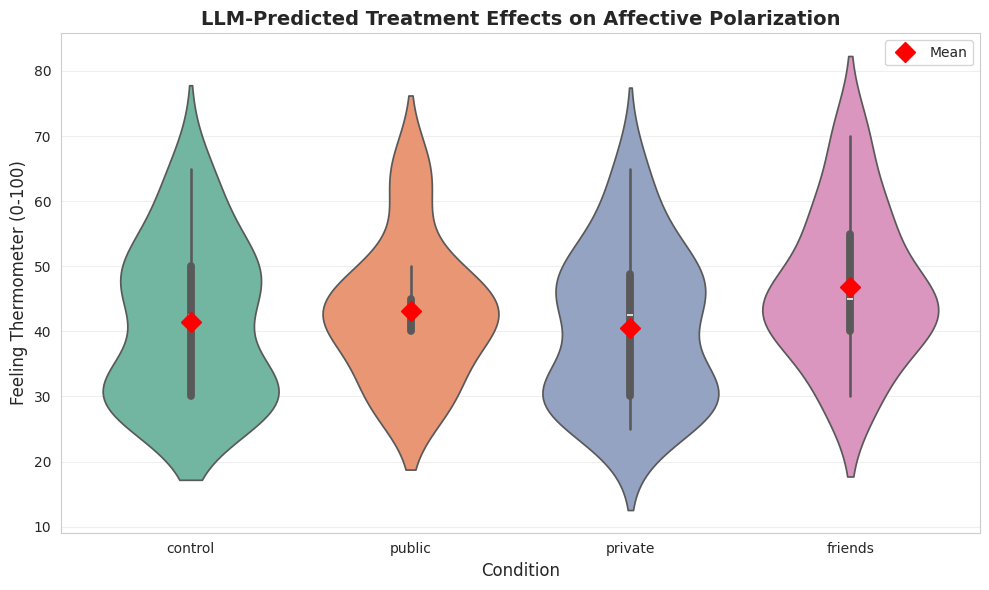

In [21]:
# Visualize predicted effects
fig, ax = plt.subplots(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=clean_data, x='condition', y='feeling_thermometer',
               order=['control', 'public', 'private', 'friends'],
               palette='Set2', ax=ax)

# Add mean markers
means = clean_data.groupby('condition')['feeling_thermometer'].mean()
for i, condition in enumerate(['control', 'public', 'private', 'friends']):
    ax.plot(i, means[condition], 'D', color='red', markersize=10,
            label='Mean' if i == 0 else '')

ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Feeling Thermometer (0-100)', fontsize=12)
ax.set_title('LLM-Predicted Treatment Effects on Affective Polarization', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



In [22]:
# Statistical tests: Compare each treatment to control
control_scores = clean_data[clean_data['condition'] == 'control']['feeling_thermometer']

print("Statistical Tests: Treatment vs. Control")
print("="*60)

for condition in ['public', 'private', 'friends']:
    treatment_scores = clean_data[clean_data['condition'] == condition]['feeling_thermometer']

    # t-test
    t_stat, p_value = stats.ttest_ind(treatment_scores, control_scores)

    # Effect size (Cohen's d)
    pooled_std = np.sqrt((treatment_scores.std()**2 + control_scores.std()**2) / 2)
    cohens_d = (treatment_scores.mean() - control_scores.mean()) / pooled_std

    print(f"\n{condition.upper()} vs. Control:")
    print(f"  Mean difference: {treatment_scores.mean() - control_scores.mean():.2f} points")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f} {'*' if p_value < 0.05 else '(n.s.)'}")
    print(f"  Cohen's d: {cohens_d:.3f}")

print("\n* = statistically significant at p < 0.05")

Statistical Tests: Treatment vs. Control

PUBLIC vs. Control:
  Mean difference: 1.82 points
  t-statistic: 0.540
  p-value: 0.5920 (n.s.)
  Cohen's d: 0.163

PRIVATE vs. Control:
  Mean difference: -0.91 points
  t-statistic: -0.258
  p-value: 0.7980 (n.s.)
  Cohen's d: -0.078

FRIENDS vs. Control:
  Mean difference: 5.45 points
  t-statistic: 1.555
  p-value: 0.1275 (n.s.)
  Cohen's d: 0.469

* = statistically significant at p < 0.05


---

## Step 5: Compare to Actual Results

**Actual Connors (2020) findings:**
- **No main treatment effects** for any condition
- Effects varied based on individual differences in social conformity
- Private and friends conditions showed some reduction in polarization
- **Conclusion**: Social pressure inflates polarization measures

**LLM predictions:**
- See results above
- Compare effect directions and magnitudes

**Questions to consider:**
1. Did the LLM predict the right **direction** of effects?
2. Are the **magnitudes** realistic?
3. Did it capture the **null main effect**?
4. What does this tell us about using LLMs for experimental forecasting?

---

---

## Reflections on Zero-shot Prediction

**What we learned:**
1. LLMs can generate plausible experimental predictions
2. Easy to test many demographic subgroups
3. Fast and cheap compared to real data collection

**Limitations:**
1. May miss subtle moderators and individual differences
2. Effect sizes may be off
3. Can't discover truly novel phenomena
4. Relies on LLM's training data biases

**Best use cases:**
- **Pre-testing** experimental designs before expensive fieldwork
- **Power analysis**: Estimate sample sizes needed
- **Exploring heterogeneity**: Which subgroups to focus on?
- **Theory development**: Generate hypotheses to test

**Always validate with real humans!**

---

# Part 2: Fine-tuned Behavioral Models (Mini Centaur)

Now we'll explore the **Centaur approach**: fine-tuning an LLM on real behavioral data.

**Key difference from Part 1:**
- Part 1 (zero-shot): LLM uses its general knowledge
- Part 2 (fine-tuned): LLM learns from actual human choices

**Example: Asch Conformity Experiment**

Classic social psychology study (1951):
- Participants judge which line matches a target line
- **Confederates** (actors) give obviously wrong answers
- **Question**: Will participants conform to group pressure?
- **Result**: ~75% of people conformed at least once

We'll use a **mini Centaur model** fine-tuned on behavioral data to predict conformity!

---

## Setup for Mini Centaur

**Important**: This section requires GPU and specific libraries.

**Recommended**: Run this in Google Colab with GPU enabled.

The model uses:
- **Llama 3.1 8B** base model
- **QLoRA fine-tuning** (efficient parameter updates)
- Pre-trained on behavioral experiments ("Minitaur")

---

In [2]:
# Install required packages (only in Colab)
# This may take a few minutes

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q unsloth transformers accelerate bitsandbytes
    print("✓ Installed packages for Colab")
else:
    print("⚠ Not in Colab - you may need to install packages manually")
    print("  Run: pip install unsloth transformers accelerate bitsandbytes")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.8/348.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [3]:
# Import libraries for fine-tuned model
try:
    from unsloth import FastLanguageModel
    import transformers
    import torch

    print("✓ Successfully imported model libraries")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    if not torch.cuda.is_available():
        print("\n⚠ Warning: No GPU detected. Model loading will be slow.")
        print("  In Colab: Runtime → Change runtime type → GPU")

except ImportError as e:
    print(f"❌ Error importing libraries: {e}")
    print("\nPlease install required packages or run in Colab with GPU.")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Successfully imported model libraries
PyTorch version: 2.8.0+cu126
CUDA available: True


---

## Load the Mini Centaur Model

We'll load a pre-trained model that has been fine-tuned on behavioral experiments.

**Model details:**
- Base: Llama 3.1 8B
- Fine-tuned using QLoRA on behavioral data
- Trained on trial-by-trial human choices
- Can predict responses in multiple experimental paradigms

**This takes ~2-3 minutes to download and load.**

---

In [4]:
# Load the mini Centaur model
print("Loading mini Centaur model...")
print("This may take 2-3 minutes on first run.\n")

try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="marcelbinz/Llama-3.1-Minitaur-8B-adapter",
        max_seq_length=32768,  # Long context for full trial histories
        dtype=None,  # Auto-detect optimal dtype
        load_in_4bit=True,  # Use 4-bit quantization to save memory
    )

    # Set model to inference mode
    FastLanguageModel.for_inference(model)

    print("✓ Model loaded successfully!")
    print(f"  Model: {model.config._name_or_path}")
    print(f"  Max sequence length: {model.config.max_position_embeddings}")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\nTroubleshooting:")
    print("  • Make sure you're using a GPU runtime in Colab")
    print("  • Check your internet connection (model downloads from HuggingFace)")

Loading mini Centaur model...
This may take 2-3 minutes on first run.

==((====))==  Unsloth 2025.11.1: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Unsloth 2025.11.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✓ Model loaded successfully!
  Model: unsloth/meta-llama-3.1-8b-bnb-4bit
  Max sequence length: 131072


In [5]:
# Create inference pipeline
pipe = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    trust_remote_code=True,
    pad_token_id=0,
    do_sample=True,  # Sample to get variation
    temperature=1.0,  # Standard temperature for behavioral simulation
    max_new_tokens=1,  # Only generate next choice token
)

print("✓ Inference pipeline ready")

Device set to use cuda:0


✓ Inference pipeline ready


---

## The Asch Conformity Experiment

**Classic study** (Asch, 1951):

1. Participants see a **target line** and three **comparison lines** (A, B, C)
2. Task: Choose which comparison line matches the target length
3. **Twist**: 6-7 confederates give wrong answers before the real participant
4. **Question**: Will the participant give the correct answer or conform?

**Example trial:**
```
Target: medium length
A: medium (CORRECT)
B: long (WRONG)
C: short (WRONG)

Confederates all say: "B"
What does participant say?
```

**Historical results:**
- ~75% of participants conformed at least once
- ~32% of all trials showed conformity
- Stronger conformity with more confederates

---

## Format of Behavioral Data for Centaur

Centaur is trained on prompts that include:

1. **Task instructions** (what the experiment is about)
2. **Full trial history** (all previous choices by this participant)
3. **Current trial** (the situation now)
4. **Question** (what should they choose next?)

**Key insight**: The model learns patterns from how humans respond across many trials, not just isolated choices.

Let's see an example:

---

In [6]:
# Example Asch conformity prompt (following Centaur format)
asch_prompt = """
You will see a target line and three comparison lines labeled A, B, and C.
In each trial, press the key for the line that matches the target in length.

Target: medium. A: medium, B: long, C: short. Others say: B B B B B B. You press <<A>>.
Target: short. A: long, B: short, C: medium. Others say: B B B B B B. You press <<B>>.
Target: long. A: long, B: short, C: medium. Others say: C C C C C C. You press <<A>>.
Target: medium. A: medium, B: long, C: short. Others say: B B B B B B. You press <<B>>.
Target: short. A: short, B: medium, C: long. Others say: C C C C C C. You press <<
""".strip()

print("Example Prompt for Centaur:")
print("="*70)
print(asch_prompt)

Example Prompt for Centaur:
You will see a target line and three comparison lines labeled A, B, and C.
In each trial, press the key for the line that matches the target in length.

Target: medium. A: medium, B: long, C: short. Others say: B B B B B B. You press <<A>>.
Target: short. A: long, B: short, C: medium. Others say: B B B B B B. You press <<B>>.
Target: long. A: long, B: short, C: medium. Others say: C C C C C C. You press <<A>>.
Target: medium. A: medium, B: long, C: short. Others say: B B B B B B. You press <<B>>.
Target: short. A: short, B: medium, C: long. Others say: C C C C C C. You press <<


---

## Generate Predictions with Mini Centaur

Now let's see what the model predicts:

**The model will:**
1. Read the full trial history
2. Notice the pattern of conformity/resistance
3. Consider the social pressure ("Others say: C C C C C C")
4. Generate the next choice token (A, B, or C)

---

In [7]:
# Generate prediction
print("Generating model prediction...\n")

output = pipe(asch_prompt)[0]['generated_text']
predicted_choice = output[len(asch_prompt):].strip()

print(f"Predicted choice: {predicted_choice}")

# Parse the choice
if 'A' in predicted_choice:
    choice_letter = 'A'
    interpretation = "INDEPENDENT (correct answer)"
elif 'C' in predicted_choice:
    choice_letter = 'C'
    interpretation = "CONFORMITY (followed group)"
else:
    choice_letter = predicted_choice
    interpretation = "UNCLEAR"

print(f"Interpretation: {interpretation}")
print(f"Correct: A | Group: C | Model: {choice_letter}")

Generating model prediction...

Predicted choice: C
Interpretation: CONFORMITY (followed group)
Correct: A | Group: C | Model: C


---

## Run Multiple Trials

Let's simulate a full participant's session:
- Multiple trials with varying conformity pressure
- Track conformity rate over time
- Compare to human behavioral patterns

---

In [8]:
def run_asch_trial(trial_history, target, correct_option, options, group_says):
    """
    Run a single Asch conformity trial

    Args:
        trial_history: String of previous trials
        target: Description of target line
        correct_option: Which option (A/B/C) is correct
        options: Dict mapping A/B/C to descriptions
        group_says: What option the confederates choose

    Returns:
        tuple: (chosen_option, conformed)
    """
    # Build trial prompt
    trial_text = f"Target: {target}. A: {options['A']}, B: {options['B']}, C: {options['C']}. Others say: {' '.join([group_says]*6)}. You press <<"

    # Full prompt with history
    full_prompt = trial_history + "\n" + trial_text if trial_history else trial_text

    # Generate prediction
    output = pipe(full_prompt)[0]['generated_text']
    prediction = output[len(full_prompt):].strip()

    # Parse choice
    if 'A' in prediction:
        choice = 'A'
    elif 'B' in prediction:
        choice = 'B'
    elif 'C' in prediction:
        choice = 'C'
    else:
        choice = 'INVALID'

    # Check if conformed
    conformed = (choice == group_says and choice != correct_option)

    # Add to history
    response_text = trial_text + choice + ">>."

    return choice, conformed, response_text

print("✓ Trial simulation function defined")

✓ Trial simulation function defined


In [11]:
# Run a simulated participant session
instructions = """You will see a target line and three comparison lines labeled A, B, and C.
In each trial, press the key for the line that matches the target in length.
"""

# Define trial sequence (mix of conformity pressure and control trials)
trials = [
    # Trial 1: Control (group gives correct answer)
    {'target': 'medium', 'correct': 'A', 'options': {'A': 'medium', 'B': 'long', 'C': 'short'}, 'group': 'A'},

    # Trial 2: Conformity pressure (group gives wrong answer)
    {'target': 'short', 'correct': 'B', 'options': {'A': 'long', 'B': 'short', 'C': 'medium'}, 'group': 'C'},

    # Trial 3: Conformity pressure
    {'target': 'long', 'correct': 'A', 'options': {'A': 'long', 'B': 'short', 'C': 'medium'}, 'group': 'C'},

    # Trial 4: Control
    {'target': 'short', 'correct': 'C', 'options': {'A': 'medium', 'B': 'long', 'C': 'short'}, 'group': 'C'},

    # Trial 5: Strong conformity pressure
    {'target': 'medium', 'correct': 'A', 'options': {'A': 'medium', 'B': 'long', 'C': 'short'}, 'group': 'B'},

    # Trial 6: Conformity pressure
    {'target': 'long', 'correct': 'B', 'options': {'A': 'short', 'B': 'long', 'C': 'medium'}, 'group': 'A'},
]

# Run simulation
print("Running Asch Conformity Simulation")
print("="*70)
print()

history = instructions
results = []

for i, trial in enumerate(trials, 1):
    choice, conformed, trial_text = run_asch_trial(
        history,
        trial['target'],
        trial['correct'],
        trial['options'],
        trial['group']
    )

    # Record result
    is_pressure_trial = (trial['group'] != trial['correct'])
    results.append({
        'trial': i,
        'correct': trial['correct'],
        'group_says': trial['group'],
        'model_chose': choice,
        'conformed': conformed,
        'pressure_trial': is_pressure_trial
    })

    # Display
    pressure_str = "[PRESSURE]" if is_pressure_trial else "[CONTROL]"
    conform_str = "→ CONFORMED" if conformed else "→ independent"

    print(f"Trial {i} {pressure_str}:")
    print(f"  Correct: {trial['correct']} | Group: {trial['group']} | Model: {choice} {conform_str}")
    print()

    # Update history
    history += "\n" + trial_text

    time.sleep(0.5)  # Slight delay between trials

# Summary
results_df = pd.DataFrame(results)
pressure_trials = results_df[results_df['pressure_trial']]
conformity_rate = pressure_trials['conformed'].mean()

print("="*70)
print("\nSummary:")
print(f"  Total trials: {len(results_df)}")
print(f"  Conformity pressure trials: {len(pressure_trials)}")
print(f"  Conformity rate: {conformity_rate*100:.1f}%")
print(f"\n  Historical human conformity rate: ~32%")
print(f"  Model's conformity rate: {conformity_rate*100:.1f}%")

Running Asch Conformity Simulation

Trial 1 [CONTROL]:
  Correct: A | Group: A | Model: A → independent

Trial 2 [PRESSURE]:
  Correct: B | Group: C | Model: B → independent

Trial 3 [PRESSURE]:
  Correct: A | Group: C | Model: B → independent

Trial 4 [CONTROL]:
  Correct: C | Group: C | Model: C → independent

Trial 5 [PRESSURE]:
  Correct: A | Group: B | Model: A → independent

Trial 6 [PRESSURE]:
  Correct: B | Group: A | Model: A → CONFORMED


Summary:
  Total trials: 6
  Conformity pressure trials: 4
  Conformity rate: 25.0%

  Historical human conformity rate: ~32%
  Model's conformity rate: 25.0%


---

## Comparing Approaches: Zero-shot vs. Fine-tuned

We've now seen both approaches:

### Part 1: Zero-shot (Hewitt et al.)
- **Input**: Demographic description + experimental setup
- **Model**: General-purpose GPT-4
- **Output**: Predicted survey response
- **Strength**: Fast, flexible, no training needed
- **Weakness**: May miss subtle psychological mechanisms

### Part 2: Fine-tuned (Centaur)
- **Input**: Full trial history in task-specific format
- **Model**: Llama 3.1 fine-tuned on behavioral data
- **Output**: Next choice given history
- **Strength**: Learns from real human behavior patterns
- **Weakness**: Requires behavioral corpus, domain-specific

---

In [12]:
# Visual comparison
comparison_data = pd.DataFrame([
    {'Approach': 'Zero-shot (GPT-4)', 'Speed': 'Fast', 'Flexibility': 'High', 'Accuracy': 'Medium', 'Training': 'None'},
    {'Approach': 'Fine-tuned (Centaur)', 'Speed': 'Medium', 'Flexibility': 'Low', 'Accuracy': 'High', 'Training': 'Required'}
])

print("Comparison of Approaches")
print("="*70)
print(comparison_data.to_string(index=False))

Comparison of Approaches
            Approach  Speed Flexibility Accuracy Training
   Zero-shot (GPT-4)   Fast        High   Medium     None
Fine-tuned (Centaur) Medium         Low     High Required


---

## Summary and Best Practices

**Key takeaways:**

1. **LLMs can predict experimental outcomes** with varying accuracy
2. **Two approaches**: Zero-shot (fast, flexible) vs. Fine-tuned (precise, domain-specific)
3. **Best use**: Pre-testing designs, exploring heterogeneity, power analysis
4. **Always validate** with real human data before publishing

**Best practices:**

1. **Use simulation for exploration**, not substitution
2. **Document everything**: Prompts, models, parameters, seeds
3. **Test sensitivity**: Try multiple prompts and models
4. **Compare to theory**: Do predictions make psychological sense?
5. **Report limitations**: Be transparent about simulation boundaries

**Ethical considerations:**

- Don't claim simulated results are real human data
- Clearly label predictions vs. actual findings
- Be cautious with novel phenomena (LLMs may be wrong)
- Consider training data biases (WEIRD populations)
- Always get real human data for final claims

---

## Further Exploration

**Try this yourself:**

1. **Modify the Connors study**:
   - Add different privacy conditions
   - Test other demographic moderators
   - Try different outcome measures

2. **Explore other experiments**:
   - Find preregistered studies at [tessexperiments.org](https://tessexperiments.org)
   - Simulate before reading results
   - Compare LLM predictions to actual findings

3. **Fine-tune your own model**:
   - Collect trial-by-trial behavioral data
   - Format as Centaur-style prompts
   - Use QLoRA to fine-tune efficiently

**Resources:**

- **Centaur model**: [marcelbinz/Llama-3.1-Minitaur-8B-adapter](https://huggingface.co/marcelbinz/Llama-3.1-Minitaur-8B-adapter)
- **Interactive demo**: [https://huggingface.co/spaces/marcelbinz/Centaur](https://huggingface.co/spaces/marcelbinz/Centaur)
- **TESS experiments**: [https://tessexperiments.org](https://tessexperiments.org)

---